In [1]:
from typing import List, Callable
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

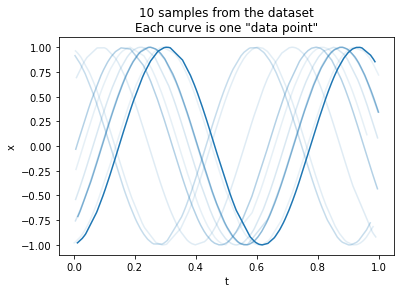

In [2]:
torch.manual_seed(123)

N, T = 200, 100
t = torch.rand(N, T, 1).sort(1)[0].to(device)
x = torch.sin(10 * t + 2 * np.pi * torch.rand(N, 1, 1).to(t))

for i in range(10):
    plt.plot(t[i,:,0].cpu().numpy(), x[i,:,0].cpu().numpy(), color='C0', alpha=1 / (i + 1))
plt.title('10 samples from the dataset\nEach curve is one "data point"')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

## Forward noising process - diffusion

In [3]:
def get_betas(steps):
    beta_start, beta_end = 1e-4, 0.2
    diffusion_ind = torch.linspace(0, 1, steps).to(device)
    return beta_start * (1 - diffusion_ind) + beta_end * diffusion_ind

diffusion_steps = 100
betas = get_betas(diffusion_steps)
alphas = torch.cumprod(1 - betas, dim=0)

In [4]:
gp_sigma = 0.05

def get_gp_covariance(t):
    s = t - t.transpose(-1, -2)
    diag = torch.eye(t.shape[-2]).to(t) * 1e-5 # for numerical stability
    return torch.exp(-torch.square(s / gp_sigma)) + diag

In [5]:
def add_noise(x, t, i):
    """
    x: Clean data sample, shape [B, S, D]
    t: Times of observations, shape [B, S, 1]
    i: Diffusion step, shape [B, S, 1]
    """
    noise_gaussian = torch.randn_like(x)
    
    cov = get_gp_covariance(t)
    L = torch.linalg.cholesky(cov)
    noise = L @ noise_gaussian
    
    alpha = alphas[i.long()].to(x)
    x_noisy = torch.sqrt(alpha) * x + torch.sqrt(1 - alpha) * noise
    
    return x_noisy, noise

## Model

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim: int, max_value: float):
        super().__init__()
        self.max_value = max_value

        linear_dim = dim // 2
        periodic_dim = dim - linear_dim

        self.scale = torch.exp(-2 * torch.arange(0, periodic_dim).float() * math.log(self.max_value) / periodic_dim)
        self.shift = torch.zeros(periodic_dim)
        self.shift[::2] = 0.5 * math.pi

        self.linear_proj = nn.Linear(1, linear_dim)

    def forward(self, t):
        periodic = torch.sin(t * self.scale.to(t) + self.shift.to(t))
        linear = self.linear_proj(t / self.max_value)
        return torch.cat([linear, periodic], -1)

class FeedForward(nn.Module):
    def __init__(self, in_dim: int, hidden_dims: List[int], out_dim: int, activation: Callable=nn.ReLU(), final_activation: Callable=None):
        super().__init__()

        hidden_dims = hidden_dims[:]
        hidden_dims.append(out_dim)

        layers = [nn.Linear(in_dim, hidden_dims[0])]

        for i in range(len(hidden_dims) - 1):
            layers.append(activation)
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))

        if final_activation is not None:
            layers.append(final_activation)

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    
class TransformerModel(nn.Module):
    def __init__(self, dim, hidden_dim, max_i, num_layers=8, **kwargs):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.t_enc = PositionalEncoding(hidden_dim, max_value=1)
        self.i_enc = PositionalEncoding(hidden_dim, max_value=max_i)

        self.input_proj = FeedForward(dim, [], hidden_dim)

        self.proj = FeedForward(3 * hidden_dim, [], hidden_dim, final_activation=nn.ReLU())

        self.enc_att = []
        self.i_proj = []
        for _ in range(num_layers):
            self.enc_att.append(nn.MultiheadAttention(hidden_dim, num_heads=1, batch_first=True))
            self.i_proj.append(nn.Linear(3 * hidden_dim, hidden_dim))
        self.enc_att = nn.ModuleList(self.enc_att)
        self.i_proj = nn.ModuleList(self.i_proj)

        self.output_proj = FeedForward(hidden_dim, [], dim)

    def forward(self, x, t, i):
        shape = x.shape

        x = x.view(-1, *shape[-2:])
        t = t.view(-1, shape[-2], 1)
        i = i.view(-1, shape[-2], 1)

        x = self.input_proj(x)
        t = self.t_enc(t)
        i = self.i_enc(i)

        x = self.proj(torch.cat([x, t, i], -1))

        for att_layer, i_proj in zip(self.enc_att, self.i_proj):
            y, _ = att_layer(query=x, key=x, value=x)
            x = x + torch.relu(y)

        x = self.output_proj(x)
        x = x.view(*shape)
        return x

In [7]:
model = TransformerModel(dim=1, hidden_dim=64, max_i=diffusion_steps).to(device)
optim = torch.optim.Adam(model.parameters())

## Training

In [8]:
def get_loss(x, t):
    i = torch.randint(0, diffusion_steps, size=(x.shape[0],))
    i = i.view(-1, 1, 1).expand_as(x[...,:1]).to(x)
    
    x_noisy, noise = add_noise(x, t, i)
    pred_noise = model(x_noisy, t, i)
    
    loss = (pred_noise - noise)**2
    return torch.mean(loss)

In [9]:
for i in range(5000):
    optim.zero_grad()
    loss = get_loss(x, t)
    loss.backward()
    optim.step()
    if i % 1000 == 0:
        print(loss.item())

1.4244734048843384
0.24812255799770355
0.09799160063266754
0.07922094315290451
0.08140101283788681


## Sampling

In [10]:
@torch.no_grad()
def sample(t):
    cov = get_gp_covariance(t)
    L = torch.linalg.cholesky(cov)

    x = L @ torch.randn_like(t)
    
    for diff_step in reversed(range(0, diffusion_steps)):
        alpha = alphas[diff_step]
        beta = betas[diff_step]

        z = L @ torch.randn_like(t)
        
        i = torch.Tensor([diff_step]).expand_as(x[...,:1]).to(device)
        pred_noise = model(x, t, i)
        
        x = (x - beta * pred_noise / (1 - alpha).sqrt()) / (1 - beta).sqrt() + beta.sqrt() * z
    return x

In [11]:
t_grid = torch.linspace(0, 1, 200).view(1, -1, 1).to(device) # Note that we can use different sequence length here without any issues
samples = sample(t_grid.repeat(10, 1, 1))

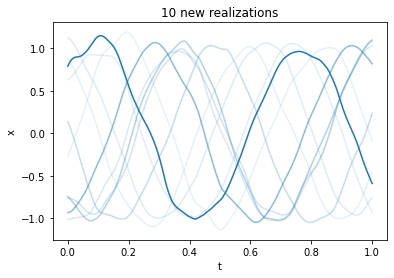

In [12]:
for i in range(10):
    plt.plot(t_grid.squeeze().detach().cpu().numpy(), samples[i].squeeze().detach().cpu().numpy(), color='C0', alpha=1 / (i + 1))
plt.title('10 new realizations')
plt.xlabel('t')
plt.ylabel('x')
plt.show()